# Long-range correlation and fractal dynamics in C. elegans: changes with aging and stress

In [1]:
processdata=False # If this is true, runs all calculations and save files on results folder. Beaware that this might take a while.

## Libraries and Settings

In [2]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [279]:
import sys
import os
import pathlib
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.stats import norm
from scipy import stats
import matplotlib.mlab as mlab
import statsmodels.api as sm
import matplotlib as mpl
import statsmodels.stats.multitest as smm
import matplotlib.ticker as plticker
import random
from scipy import optimize
from matplotlib import ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [4]:
# Locals
from modules.functions import *

In [5]:
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['xtick.minor.pad'] = 10
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['ytick.minor.pad'] = 10
plt.rcParams['xtick.direction']="in"
plt.rcParams['ytick.direction']="in"
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True


sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
sns.set_style({"xtick.direction": "in",
               "ytick.direction": "in",
               'xtick.color': 'black',
               'ytick.color': 'black',
               'text.color': 'black',
               'axes.edgecolor': 'black',
               'axes.labelcolor': 'black',
               'text.color': 'black'})


# Functions

In [297]:
def box_plot_age(data_to_plot,ymin=0,ymax=2,ylabel='y'):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)

        
    ax.set_xticklabels(['1', '2','3', '4','5', '6'])
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Age [days]')
    ax.set_ylabel(ylabel)
    increase_font(ax,20)

def matrix_plot_age(conf_arr):
    conf_arr=np.array(conf_arr)


    fig = plt.figure(figsize=(4,3.5))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=7)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = '123456'
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Age [days]',fontsize=20)
    ax.set_ylabel('Age [days]',fontsize=20)
    ax.tick_params(labelsize=20)
    
def test2samples_age(data_to_plot):
    indexes=[]
    new_p_age=[]
    for j in range(0,6):
        for i in range(0,6):
            s1=[x for x in data_to_plot[j] if str(x) != 'nan']
            s2=[x for x in data_to_plot[i] if str(x) != 'nan']
            #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
            ustat, pvalue=stats.mannwhitneyu(s1,s2)

            if i <j:
                new_p_age.append(pvalue)
                indexes.append((i, j))


    # Plot p-values with correction for multiple testing    
    a, corrected_p, c, d = smm.multipletests(new_p_age, method='b')

    p_array = np.ones((6, 6))
    for (i, j), pv in zip(indexes, corrected_p):
        p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


    ak=[1,2,3,4,5,6]
    p = pd.DataFrame(p_array, index=ak, columns=ak)

    return p

In [298]:
def box_plot_temp(data_to_plot,ymin=0,ymax=2,ylabel='y'):
    # Create a figure instance
    fig = plt.figure(1, figsize=(5,3.5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data_to_plot, patch_artist=True,showfliers=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#bdbdbd',markersize=4,zorder=3)
        
    ax.set_xticklabels(['15', '20','25'])
    #ax.grid()
    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_ylim(ymin,ymax)
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel(ylabel)
    increase_font(ax,20)
    
def matrix_plot_temp(conf_arr):
    conf_arr=np.array(conf_arr)
    fig = plt.figure(figsize=(4,3.5))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.Blues, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=7)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=18)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    alphabet = ["15","20","25"]
    plt.xticks(range(width), alphabet[:width])
    plt.yticks(range(height), alphabet[:height])
    ax.set_xlabel('Temperature [°C]',fontsize=20)
    ax.set_ylabel('Temperature [°C]',fontsize=20)
    ax.tick_params(labelsize=20)
    
    
def test2samples_temp(data_to_plot):
    indexes=[]
    new_p_t=[]
    for j in range(0,3):
        for i in range(0,3):
            s1=[x for x in data_to_plot[j] if str(x) != 'nan']
            s2=[x for x in data_to_plot[i] if str(x) != 'nan']
            #tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
            ustat, pvalue=stats.mannwhitneyu(s1,s2)
            if i <j:
                new_p_t.append(pvalue)
                indexes.append((i, j))


    # Plot p-values with correction for multiple testing    
    a, corrected_p, c, d = smm.multipletests(new_p_t, method='b')

    p_array = np.ones((3, 3))
    for (i, j), pv in zip(indexes, corrected_p):
        p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)


    ak=[15,20,25]
    p = pd.DataFrame(p_array, index=ak, columns=ak)
    return p


# Data summary

In [7]:
datainfo()

Aging data set summary


   Age  # tracks
0    1       244
1    2       190
2    3       162
3    4       198
4    5       224
5    6        66


Temperature data set summary

   Temperature  # tracks
0           15        67
1           20        48
2           25        64


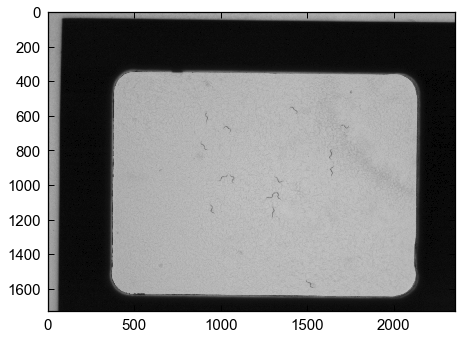

In [8]:
figpath="../data/20151026_132836-copper-15worms-N2-day1-standard-c3600170.png"

import matplotlib.image as mpimg
image = mpimg.imread(figpath)
plt.imshow(image, cmap='gray')

plt.show()


In [9]:
figpath="../data/track.pdf"
from IPython.display import IFrame
IFrame(figpath, width=600, height=400)

# Aging data set

## Mean Square Displacement

### Fitting

In [10]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [7]:
df_x,df_y=read_tracks(tracks)
variance=msd(df_x,df_y)

In [10]:
if processdata==True:
    for age in [1,2,3,4,5,6]:
        msd_by_age(age)

In [160]:
msd_aging=pd.DataFrame()
age=1
df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
msd_aging['time']=df['time']
for age in [1,2,3,4,5,6]:
    df=pd.read_csv("../results/msd_age-{}.csv".format(age),index_col=0)
    msd_aging[str(age)]=df['variance']

[ 2.24955812  1.6530972   1.70285396]
[ 0.01200987  0.01016612  0.014524  ]


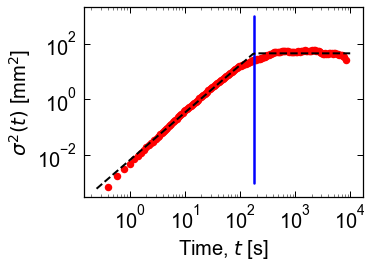

[ 2.52711639  1.45963527  1.59739281]
[ 0.01566148  0.01385582  0.01511838]


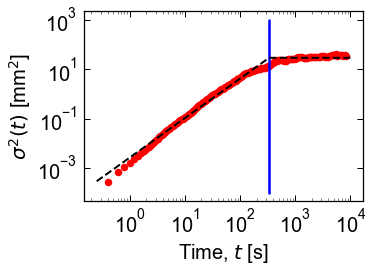

[ 2.41769507  1.5263808   1.69256481]
[ 0.01185721  0.0105962   0.01293123]


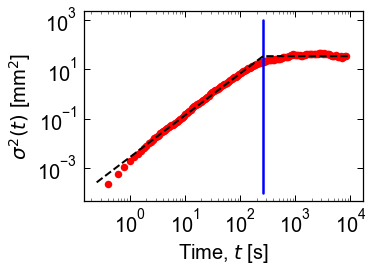

[ 2.31520528  1.69634574  1.65232543]
[ 0.01457774  0.0123266   0.01645663]


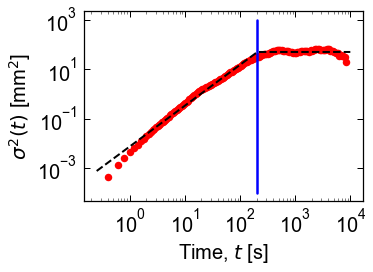

[ 2.36308505  1.63747631  1.67231308]
[ 0.01546792  0.01346711  0.0171887 ]


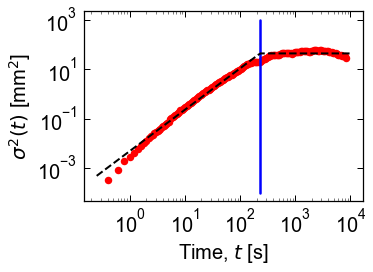

[ 2.41632597  1.6540787   1.61540052]
[ 0.02039047  0.01740241  0.02123729]


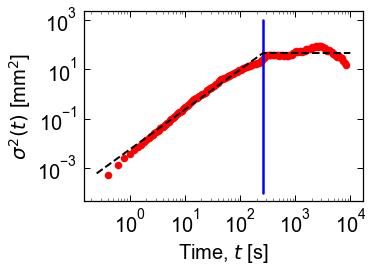

In [161]:
exp=[]
experror=[]
minb=np.array([np.nan,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])/1000
for i in [1,2,3,4,5,6]:
    y=np.log10(msd_aging[str(i)].tolist()[1:])
    x=np.log10(msd_aging["time"].tolist()[1:])
    
    xw, yw=winm(x,y,200)
    xw2, yw2=winm(x,y,1000)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) #x0, y0, k1
    print(p)
    exp.append(p[2])
    experror.append(np.sqrt(np.diag(pcov))[2])

    print(np.sqrt(np.diag(pcov)))
    xd = np.linspace(-0.6, 4, 100)
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
             ylabel="$\sigma^2(t)$ [mm$^2$]")
    locy = plticker.MultipleLocator(base=1^10) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    

    ax.loglog(10**np.array(xw),10**np.array(yw), ".r",markersize=15)
    ax.loglog([10**p[0],10**p[0]],[minb[i],10**3],"-b",linewidth=2.5)
    ax.loglog(10**xd, 10**piecewise_linear(xd, *p),"--k",linewidth=2)

    increase_font(ax,fontsize=20)
    plt.savefig("../figures/msd_age_"+str(i)+".pdf",bbox_inches='tight')
    plt.show()

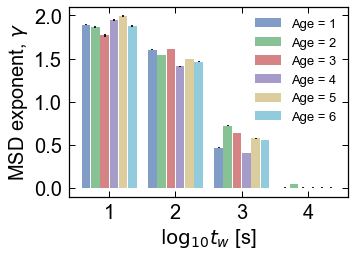

In [162]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax = plt.subplot(111, xlabel="$\log_{10} t_w$ [s]", 
         ylabel="MSD exponent, $\gamma$")

ind = np.arange(4)  # the x locations for the groups
width = 0.13# the width of the bars
ax.set_xticks(ind + 3*(width+0.03))
step=0
for i in range(1,7,1):
   
    df=msd_aging[["time",str(i)]].copy()
    df=df.apply(np.log10)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna()


    experror=[]
    result=[]
    for w in np.arange(1,5,1):
        df2=df[df.time<w].copy()
        if w==0:
            df2=df2
        else:
            df2=df2[df2.time>w-1]

        y=df2[str(i)].tolist()
        x=df2["time"].tolist()

        param_bounds=([0,-np.inf],[2,np.inf])
        popt, pcov = optimize.curve_fit(line, x, y,bounds=param_bounds) 
        result.append([w+i/10,popt[0]])
        experror.append(np.sqrt(np.diag(pcov))[0])


    yerr=np.asarray(experror)
    exp_means=[result[k][1] for k in range(0,4)]


    ax.bar(ind + width+step, exp_means, width, yerr=yerr,alpha=0.7,label="Age = "+str(i))
    step=step+ width+0.01


ax.set_xticklabels(('1', '2', '3', '4','5'))
locy = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)

ax.legend(fontsize=13) 
increase_font(ax,fontsize=20)
plt.savefig("../figures/msd_aging_fit.pdf",bbox_inches='tight')

### Bootstrapping


In [29]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

In [ ]:
if processdata==True:
    data_plot=[]
    for age in [1,2,3,4,5,6]:
        df_x,df_y=read_dataset("age",label=age)
        slope_bootstrapping=[]
        for i in range(0,100):
            print(age,i)
            slope=slope_random_sample(df_x,df_y)
            slope_bootstrapping.append(slope)
        data_plot.append(slope_bootstrapping)
        data_plot = pd.DataFrame(data_plot)
        data_plot.to_csv('../results/msd_bootstrapping_{}.csv'.format(age), index=False, header=False)


In [286]:
data_to_plot=[]
for age in [1,2,3,4,5,6]:
    df=pd.read_csv('../results/msd_bootstrapping_{}.csv'.format(age), index_col=None,header=None)
    data_to_plot.append(np.array(df))

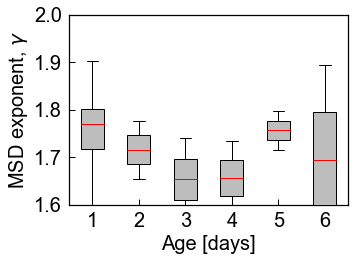

In [287]:
box_plot_age(data_to_plot,ymin=1.6,ymax=2,ylabel='MSD exponent, $\gamma$')
plt.savefig('../figures/age_msd.pdf', bbox_inches='tight')

In [ ]:
p=test2samples_age(data_to_plot)
matrix_plot_age(p)
plt.savefig('../figures/age_msd_matrix.pdf', bbox_inches='tight')

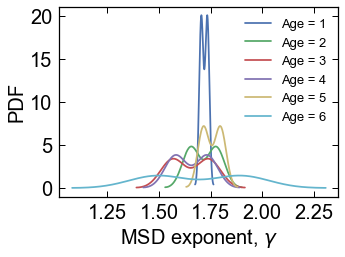

In [205]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(data_to_plot[age],hist=False, rug=False,label="Age = "+str(age+1))

ax.legend(fontsize=13) 
ax.set_xlabel('MSD exponent, $\gamma$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/age_msd_dist.pdf', bbox_inches='tight')

In [206]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(data_to_plot[age], 'norm'))

KstestResult(statistic=0.95855382336556383, pvalue=0.082892353268872343)
KstestResult(statistic=0.96216662235903117, pvalue=0.07566675528193767)
KstestResult(statistic=0.95902954906230831, pvalue=0.081940901875383387)
KstestResult(statistic=0.95846237570553006, pvalue=0.083075248588939887)
KstestResult(statistic=0.96384416621861368, pvalue=0.07231166756277263)
KstestResult(statistic=0.97094349396741064, pvalue=0.058113012065178715)


## Fractal dimension

In [164]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [165]:
df=df_tracks[20]

series="mov_forward"

In [166]:
df.head()

,time,x,y,speed,head_speed,mov_forward
8731,1800.0,17.471524,19.859558,0.007864,0.022083,0.0
8732,1800.2,17.470061,19.858975,0.006170,0.110416,0.0
8733,1800.4,17.467819,19.858421,0.009054,0.058888,0.0
8734,1800.6,17.466109,19.858260,0.006731,0.103054,0.0
8735,1800.8,17.463902,19.858138,0.008663,0.036805,0.0


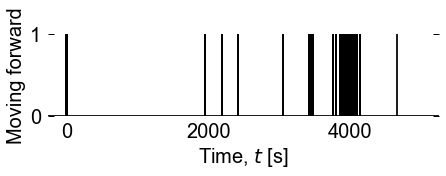

In [167]:
names=["Moving forward"]
fontsize=20
for k in range(0,len(names)):
    gs = gridspec.GridSpec(1,1)
    fig = plt.figure(figsize=(7,1.5))
    
    ax0 = fig.add_subplot(gs[0,0])
    x=np.array(df[["time"]][df.time<5000]).ravel()
    y1=np.array(df[["mov_forward"]][df.time<5000]).ravel()
    ax0.vlines(x, 0, y1, colors='k', linestyles='solid')
    ax0.acorr(x,color='k')
        
    ax0.set_ylim(0,1)
    #ax0.set_xlim(0,2000)
    ax0.locator_params(axis='x',nbins=5)
    ax0.locator_params(axis='y',nbins=1)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    
    ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    
    
    plt.ylabel("Moving forward") ; plt.xlabel('Time, $t$ [s]') ;

    increase_font(ax0,20)
    

0.617976399542 0.0173392052298


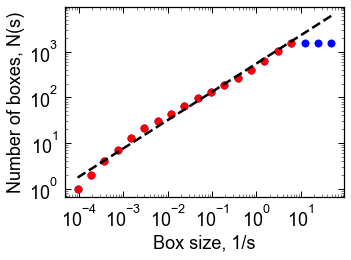

In [168]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df,std_err)
fractal_plot(r,N,A,Df,drop_first_points,drop_last_points,series)
plt.savefig("../figures/fd_age.pdf",bbox_inches='tight')
plt.show()

In [82]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df)

0.725835383861


In [84]:
if processdata==True:
    for age in [1,2,3,4,5,6]:
        print(age)
        sample_dir=pathlib.Path('../data/age/{}'.format(age))
        tracks=[i for i in sample_dir.glob('*')]

        df_tracks=[]
        for track in tracks:
            df_track=pd.read_csv(str(track), index_col=0)
            df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
            df.sort_values(by='time',inplace=True)
            if len(df)>100:
                df_tracks.append(df)

        fd_exp=[]
        for track in df_tracks:
            df=track
            series="mov_forward"
            eventtimes = timeseriestoeventtimes(df, series)
            if sum(eventtimes) > 0:
                r, N = nbox_boxsize(eventtimes, number_of_sizes=20)
                if sum(N) > 0:
                    list_df, error_df = find_stable_slope(r, N, 3)
                    drop_last_points = -(len(np.array(list_df)[np.array(list_df) < 0.1]) + 1)
                    drop_first_points = 0
                    Df, A, r_value, p_value, std_err = fit_data(
                        r[drop_first_points:drop_last_points],
                        N[drop_first_points:drop_last_points])
                    if len(r) > abs(drop_last_points):
                        fd_exp.append(Df)

        data_plot = pd.DataFrame(fd_exp)
        data_plot.to_csv('../results/fd_exp-{}.csv'.format(age), index=False, header=False)


In [289]:
df_aging=pd.DataFrame()

for age in [1,2,3,4,5,6]:
    df=pd.read_csv('../results/fd_exp-{}.csv'.format(age),names=[age])
    df_aging[age]=df[age]

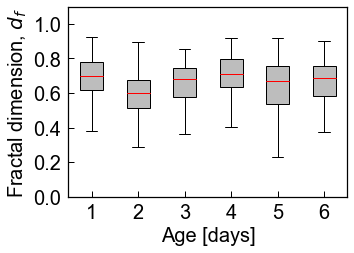

In [290]:
data_to_plot=[list(df_aging[x].dropna()) for x in list(df_aging.columns)]
box_plot_age(data_to_plot,ymin=0,ymax=1.1,ylabel='Fractal dimension, $d_f$')
plt.savefig('../figures/age_fractal_dimension.pdf', bbox_inches='tight')

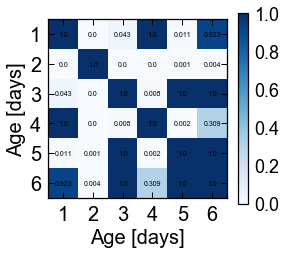

In [299]:
p=test2samples_age(data_to_plot)
matrix_plot_age(p)
plt.savefig('../figures/age_fractal_dimension_matrix.pdf', bbox_inches='tight')

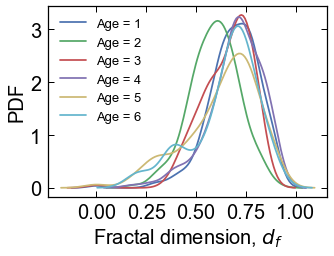

In [126]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(data_to_plot[age],hist=False, rug=False,label="Age = "+str(age+1))

    
ax.legend(fontsize=13) 
ax.set_xlabel('Fractal dimension, $d_f$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/age_fractal_dimension_dist.pdf', bbox_inches='tight')

In [127]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(data_to_plot[age], 'norm'))

KstestResult(statistic=0.64079596118161819, pvalue=0.0)
KstestResult(statistic=0.60741139594615468, pvalue=0.0)
KstestResult(statistic=0.64164459658193351, pvalue=0.0)
KstestResult(statistic=0.62774377929223735, pvalue=0.0)
KstestResult(statistic=0.56439400073631574, pvalue=0.0)
KstestResult(statistic=0.59568894619574675, pvalue=0.0)


## DFA

In [207]:
age=1
sample_dir=pathlib.Path('../data/age/{}'.format(age))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [209]:
df_tracks[0].head()

,time,x,y,speed,head_speed,mov_forward
8728,1800.0,7.460823,4.663983,0.059403,0.008879,1.0
8729,1800.2,7.468787,4.655871,0.055030,0.008879,1.0
8730,1800.4,7.476050,4.648023,0.051763,0.035518,1.0
8731,1800.6,7.487224,4.635142,0.082550,0.186469,1.0
8732,1800.8,7.494072,4.626237,0.054379,0.106554,1.0


In [128]:
if processdata==True:
    for age in [1,2,3,4,5,6]:
        print(age)
        sample_dir=pathlib.Path('../data/age/{}'.format(age))
        tracks=[i for i in sample_dir.glob('*')]

        df_tracks=[]
        for track in tracks:
            df_track=pd.read_csv(str(track), index_col=0)
            df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
            df.sort_values(by='time',inplace=True)
            if len(df)>100:
                df_tracks.append(df)
        for i in range(0,len(df_tracks)):
            track=df_tracks[i]
            y=np.array(track["speed"])
            df=dfa(y,order=1)
            df.to_csv("../results/dfa/speed-{}-{}.csv".format(age,i))
            track=df_tracks[i]
            y=np.array(track["head_speed"])
            df=dfa(y,order=1)
            df.to_csv("../results/dfa/head_speed-{}-{}.csv".format(age,i))

### Speed

In [129]:
dfa_tracks=[]
for age in [1,2,3,4,5,6]:
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/speed-{}-{}.csv".format(age,i))
        temp.append(df)
    dfa_tracks.append(temp)    

In [130]:
dfa_age_list=[pd.concat(dfa_tracks[age]) for age in [0,1,2,3,4,5]]

-2.716717220705364 0.9492029549110448 0.0201068846446


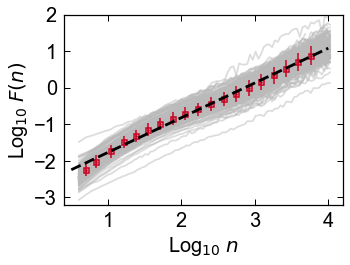

-2.8054812470532617 0.9162203054595471 0.0205734031484


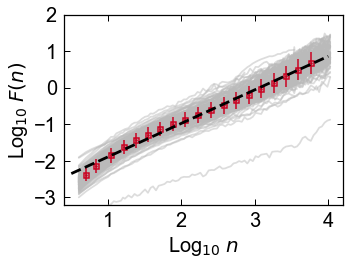

-2.7677411141532335 0.9383039066292889 0.0221102934512


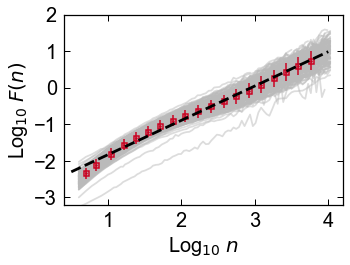

-2.7741040506661 0.9661908566432974 0.0214913573453


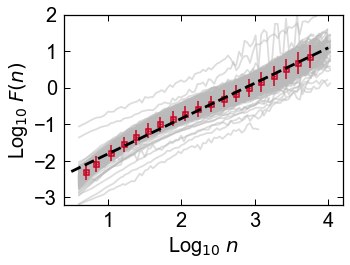

-2.8514397971211327 0.9543074590481191 0.0221234084174


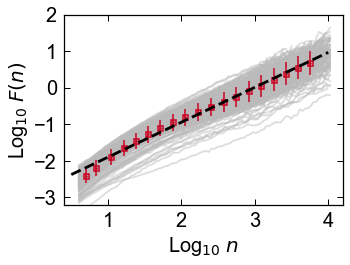

-2.9112086811902333 0.9615514049895666 0.0196013656713


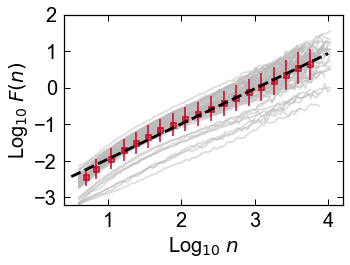

In [131]:
slope_age1=[]
slope_age_error1=[]
for age in range(0,6):
    dataf=dfa_age_list[age].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[:],fw[:])
    intercept, slope = result.params.tolist()
    slope_age1.append(slope)
    slope_age_error1.append(result.bse[1])
    print(intercept, slope,result.bse[1])

    fig, ax = plt.subplots(figsize=(5,3.5))

    for track in range(0,len(dfa_tracks[age])):
         ax.plot(dfa_tracks[age][track].n,dfa_tracks[age][track].F,color="#bababa",alpha=0.5)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')

    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_ylim(-3.2,2)
    plt.savefig("../figures/age_dfa_speed_"+str(age+1)+".pdf",bbox_inches='tight')
    plt.show()

In [132]:
age_list_slope=[]
for age in range(0,6,1):
    temp=[]
    for i in range(0,len(dfa_tracks[age])):
        result=linmodel_fit(dfa_tracks[age][i]["n"],dfa_tracks[age][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    age_list_slope.append(temp)

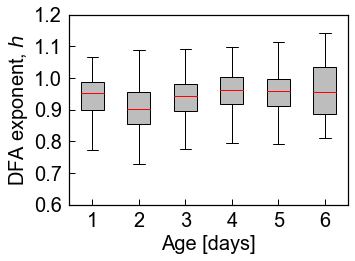

In [136]:
data_to_plot=age_list_slope
box_plot_age(data_to_plot,ymin=0.6,ymax=1.2,ylabel='DFA exponent, $h$')
plt.savefig('../figures/age_speed_dfa.pdf', bbox_inches='tight')

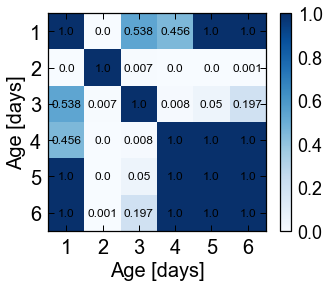

In [138]:
p=test2samples_age(data_to_plot)
matrix_plot_age(p)
plt.savefig('../figures/age_speed_dfa_matrix.pdf', bbox_inches='tight')

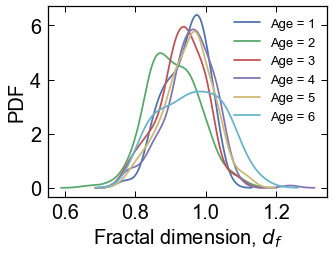

In [139]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(data_to_plot[age],hist=False, rug=False,label="Age = "+str(age+1))

    
ax.legend(fontsize=13) 
ax.set_xlabel('Fractal dimension, $d_f$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/age_speed_dfa_dist.pdf', bbox_inches='tight')

In [140]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(data_to_plot[age], 'norm'))

KstestResult(statistic=0.77758808505867449, pvalue=0.0)
KstestResult(statistic=0.76156785346679257, pvalue=0.0)
KstestResult(statistic=0.77606423835374794, pvalue=0.0)
KstestResult(statistic=0.77619706197275185, pvalue=0.0)
KstestResult(statistic=0.77697443063240978, pvalue=0.0)
KstestResult(statistic=0.79094860516243937, pvalue=0.0)


### Head speed 

In [141]:
dfa_tracks=[]
for age in [1,2,3,4,5,6]:
    sample_dir=pathlib.Path('../data/age/{}'.format(age))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/head_speed-{}-{}.csv".format(age,i),index_col=0)
        temp.append(df)
    dfa_tracks.append(temp)

age_list_slope=[]
for age in range(0,6,1):
    temp=[]
    for i in range(0,len(dfa_tracks[age])):
        result=linmodel_fit(dfa_tracks[age][i]["n"],dfa_tracks[age][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    age_list_slope.append(temp)

In [142]:
dfa_age_list=[pd.concat(dfa_tracks[age]) for age in [0,1,2,3,4,5]]

-2.1272324426229385 0.780563447650495 0.00915931896194


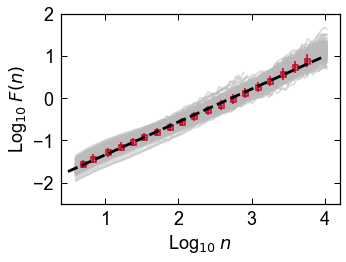

-2.2050136251398675 0.7768068000420008 0.00703823729295


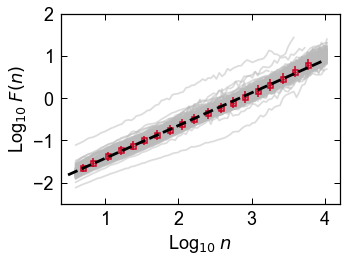

-2.1371839351220756 0.771309522482492 0.00430982315305


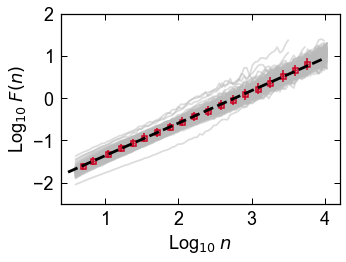

-2.0876329248047187 0.7792836717856465 0.00392672539634


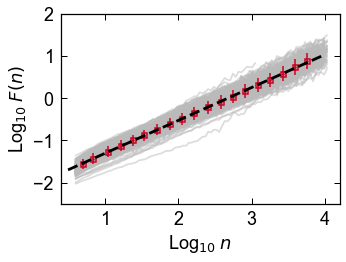

-2.140119588008993 0.7820346087106338 0.00215566397693


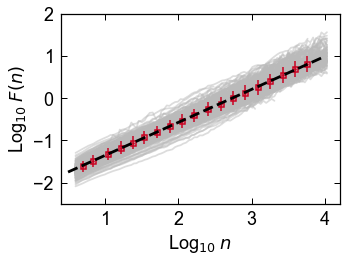

-2.182291658117915 0.8013326973670273 0.00346443997759


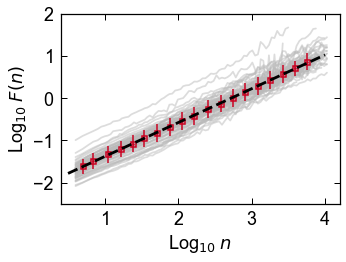

In [143]:
slope_age1=[]
slope_age_error1=[]
for age in range(0,6):
    dataf=dfa_age_list[age].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[:],fw[:])
    intercept, slope = result.params.tolist()
    slope_age1.append(slope)
    slope_age_error1.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5,3.5))


    for track in range(0,len(dfa_tracks[age])):
         ax.plot(dfa_tracks[age][track].n,dfa_tracks[age][track].F,color="#bababa",alpha=0.5)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')

    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_ylim(-2.5,2)

    plt.savefig("../results/age_dfa_head_speed_"+str(age+1)+".pdf",bbox_inches='tight')
    plt.show()

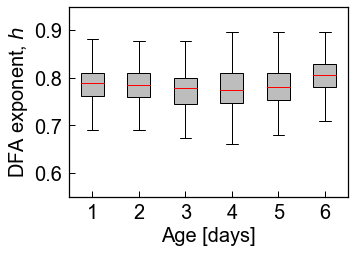

In [150]:
data_to_plot=age_list_slope
box_plot_age(data_to_plot,ymin=0.55,ymax=0.95,ylabel='DFA exponent, $h$')
plt.savefig('../figures/age_dfa_head_speed.pdf', bbox_inches='tight')

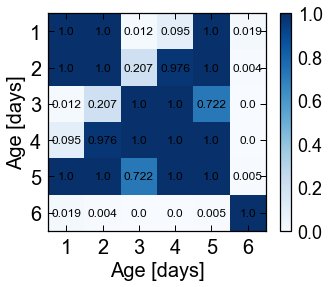

In [152]:
p=test2samples_age(data_to_plot)
matrix_plot_age(p)
plt.savefig('../figures/age_dfa_head_speed_matrix.pdf', bbox_inches='tight')

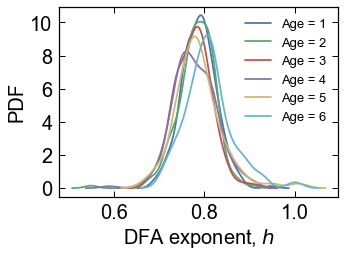

In [154]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for age in [0,1,2,3,4,5]:
    sns.distplot(data_to_plot[age],hist=False, rug=False,label="Age = "+str(age+1))

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/age_dfa_head_speed_dist.pdf', bbox_inches='tight')

In [153]:
for age in [0,1,2,3,4,5]:
    print(stats.kstest(age_list_slope[age], 'norm'))

KstestResult(statistic=0.75518186172554946, pvalue=0.0)
KstestResult(statistic=0.74644232167244839, pvalue=0.0)
KstestResult(statistic=0.74986805093275066, pvalue=0.0)
KstestResult(statistic=0.74064583024326458, pvalue=0.0)
KstestResult(statistic=0.74597427756171519, pvalue=0.0)
KstestResult(statistic=0.76124648631152902, pvalue=0.0)


# Temperature data set

## Mean Square Displacement


### Fitting

In [169]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

In [170]:
if processdata==True:
    for temperature in [15,20,25]:
        msd_by_temp(temperature)

In [171]:
msd_temp=pd.DataFrame()
temperature=15
df=pd.read_csv("../results/msd_temperature-{}.csv".format(temperature),index_col=0)
msd_temp['time']=df['time']
for temperature in [15,20,25]:
    df=pd.read_csv("../results/msd_temperature-{}.csv".format(temperature),index_col=0)
    msd_temp[str(temperature)]=df['variance']

[ 2.35330532  1.91347626  1.8057729 ]
[ 0.01021964  0.00945762  0.01234775]


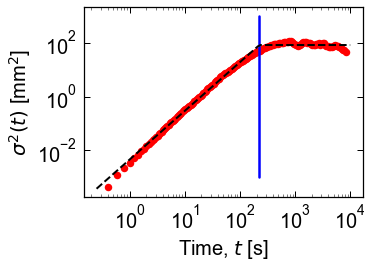

[ 2.11249271  1.82922847  1.83096301]
[ 0.01639883  0.01411331  0.02313206]


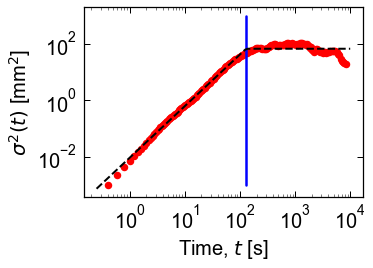

[ 2.23261111  1.75201581  1.80650663]
[ 0.0109549   0.00971492  0.01420025]


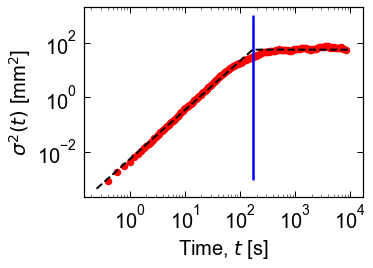

In [172]:
exp=[]
experror=[]
for i in [15,20,25]:
    y=np.log10(msd_temp[str(i)].tolist()[1:])
    x=np.log10(msd_temp["time"].tolist()[1:])
    
    xw, yw=winm(x,y,200)
    xw2, yw2=winm(x,y,1000)
    xw, yw=np.array(xw), np.array(yw)

    param_bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,2])
    p , pcov = optimize.curve_fit(piecewise_linear, xw[1:], yw[1:],bounds=param_bounds) #x0, y0, k1
    print(p)
    exp.append(p[2])
    experror.append(np.sqrt(np.diag(pcov))[2])

    print(np.sqrt(np.diag(pcov)))
    xd = np.linspace(-0.6, 4, 100)
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax = plt.subplot(111, xlabel="Time, $t$ [s]", 
             ylabel="$\sigma^2(t)$ [mm$^2$]")
    locy = plticker.MultipleLocator(base=1^10) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    

    ax.loglog(10**np.array(xw),10**np.array(yw), ".r",markersize=15)
    ax.loglog([10**p[0],10**p[0]],[10**-3,10**3],"-b",linewidth=2.5)
    ax.loglog(10**xd, 10**piecewise_linear(xd, *p),"--k",linewidth=2)

    increase_font(ax,fontsize=20)
    plt.savefig("../figures/msd_temp_"+str(i)+".pdf",bbox_inches='tight')
    plt.show()

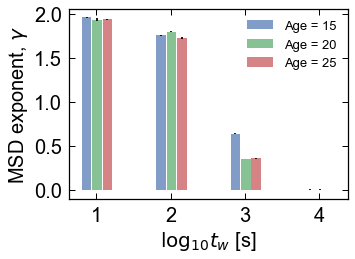

In [173]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax = plt.subplot(111, xlabel="$\log_{10} t_w$ [s]", 
         ylabel="MSD exponent, $\gamma$")

ind = np.arange(4)  # the x locations for the groups
width = 0.13# the width of the bars
ax.set_xticks(ind + 2*(width))
step=0
for i in [15,20,25]:
   
    df=msd_temp[["time",str(i)]].copy()
    df=df.apply(np.log10)
    df=df.replace([np.inf, -np.inf], np.nan)
    df=df.dropna()


    experror=[]
    result=[]
    for w in np.arange(1,5,1):
        df2=df[df.time<w].copy()
        if w==0:
            df2=df2
        else:
            df2=df2[df2.time>w-1]

        y=df2[str(i)].tolist()
        x=df2["time"].tolist()

        param_bounds=([0,-np.inf],[2,np.inf])
        popt, pcov = optimize.curve_fit(line, x, y,bounds=param_bounds) 
        result.append([w+i/10,popt[0]])
        experror.append(np.sqrt(np.diag(pcov))[0])


    yerr=np.asarray(experror)
    exp_means=[result[k][1] for k in range(0,4)]


    ax.bar(ind + width+step, exp_means, width, yerr=yerr,alpha=0.7,label="Age = "+str(i))
    step=step+ width+0.01



ax.set_xticklabels(('1', '2', '3','4'))
locy = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(locy)

ax.legend(fontsize=13) 
increase_font(ax,fontsize=20)
plt.savefig("../figures/msd_temp_fit.pdf",bbox_inches='tight')

### Bootstrapping


In [193]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

In [176]:
if processdata==True:
    for t in [15,20,25]:
        df_x,df_y=read_dataset("temperature",label=t)
        data_plot=[]
        slope_bootstrapping=[]
        for i in range(0,100):
            print(t,i)
            slope=slope_random_sample(df_x,df_y)
            slope_bootstrapping.append(slope)
        data_plot.append(slope_bootstrapping)
        data_plot = pd.DataFrame(data_plot)
        data_plot.to_csv('../results/msd_bootstrapping_{}.csv'.format(t), index=False, header=False)

In [211]:
data_to_plot=[]
for temp in [15,20,25]:
    df=pd.read_csv('../results/msd_bootstrapping_{}.csv'.format(temp), index_col=None,header=None)
    data_to_plot.append(np.array(df))

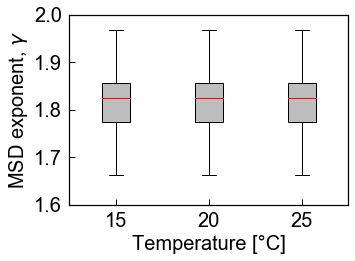

In [212]:
box_plot_temp(data_to_plot,ymin=1.6,ymax=2,ylabel='MSD exponent, $\gamma$')
plt.savefig('../figures/temp_msd.pdf', bbox_inches='tight')

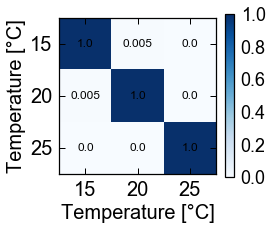

In [281]:
p=test2samples_temp(np.array(data_to_plot))
matrix_plot_temp(p)
plt.savefig('../figures/temp_msd_matrix.pdf', bbox_inches='tight')

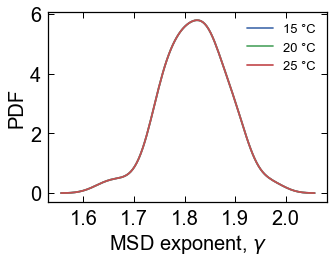

In [217]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(data_to_plot[t],hist=False, rug=False,label=str(t*5+15)+" °C")

ax.legend(fontsize=13) 
ax.set_xlabel('MSD exponent, $\gamma$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/temp_msd_dist.pdf', bbox_inches='tight')

In [216]:
for t in [0,1,2]:
    print(stats.kstest(data_to_plot[t], 'norm'))

KstestResult(statistic=0.97615429186644254, pvalue=0.047691416267114928)
KstestResult(statistic=0.97615429186644254, pvalue=0.047691416267114928)
KstestResult(statistic=0.97615429186644254, pvalue=0.047691416267114928)


## Fractal dimension


In [218]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [219]:
df=df_tracks[20]

series="mov_forward"

In [220]:
df.head()

,time,x,y,speed,head_speed,mov_forward
8962,1800.0,10.238871,20.885751,0.012713,0.032543,0.0
8963,1800.2,10.239461,20.888503,0.016259,0.075935,0.0
8964,1800.4,10.239992,20.892161,0.021346,0.010848,0.0
8965,1800.6,10.240566,20.895096,0.017278,0.097630,0.0
8966,1800.8,10.241316,20.897688,0.015582,0.032543,0.0


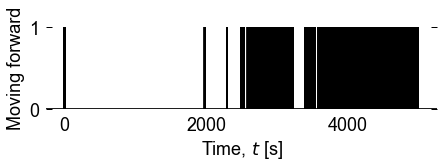

In [221]:
names=["Moving forward"]
fontsize=20
for k in range(0,len(names)):
    gs = gridspec.GridSpec(1,1)
    fig = plt.figure(figsize=(7,1.5))
    
    ax0 = fig.add_subplot(gs[0,0])
    x=np.array(df[["time"]][df.time<5000]).ravel()
    y1=np.array(df[["mov_forward"]][df.time<5000]).ravel()
    ax0.vlines(x, 0, y1, colors='k', linestyles='solid')
    ax0.acorr(x,color='k')
        
    ax0.set_ylim(0,1)
    #ax0.set_xlim(0,2000)
    ax0.locator_params(axis='x',nbins=5)
    ax0.locator_params(axis='y',nbins=1)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)
    
    ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off
    
    
    
    plt.ylabel("Moving forward") ; plt.xlabel('Time, $t$ [s]') ;

    increase_font(ax0,18)
    

0.753226535766 0.00697731946344


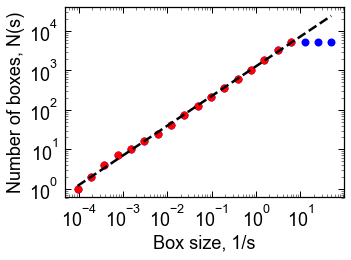

In [222]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df,std_err)
fractal_plot(r,N,A,Df,drop_first_points,drop_last_points,series)
plt.show()

In [223]:
U=timeseriestoeventtimes(df,series)
r, N =nbox_boxsize(U,number_of_sizes=20)
list_df, error_df=find_stable_slope(r,N,3)
drop_last_points=-(len(np.array(list_df)[np.array(list_df)<0.1])+1)
drop_first_points=0
Df, A, r_value, p_value, std_err =fit_data(r[drop_first_points:drop_last_points],N[drop_first_points:drop_last_points])
print(Df)

0.753226535766


In [224]:
if processdata==True:
    for temperature in [15,20,25]:
        print(temperature)
        sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
        tracks=[i for i in sample_dir.glob('*')]

        df_tracks=[]
        for track in tracks:
            df_track=pd.read_csv(str(track), index_col=0)
            df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
            df.sort_values(by='time',inplace=True)
            if len(df)>100:
                df_tracks.append(df)

        fd_exp=[]
        for track in df_tracks:
            df=track
            series="mov_forward"
            eventtimes = timeseriestoeventtimes(df, series)
            if sum(eventtimes) > 0:
                r, N = nbox_boxsize(eventtimes, number_of_sizes=20)
                if sum(N) > 0:
                    list_df, error_df = find_stable_slope(r, N, 3)
                    drop_last_points = -(len(np.array(list_df)[np.array(list_df) < 0.1]) + 1)
                    drop_first_points = 0
                    Df, A, r_value, p_value, std_err = fit_data(
                        r[drop_first_points:drop_last_points],
                        N[drop_first_points:drop_last_points])
                    if len(r) > abs(drop_last_points):
                        fd_exp.append(Df)

        data_plot = pd.DataFrame(fd_exp)
        data_plot.to_csv('../results/fd_exp-{}.csv'.format(temperature), index=False, header=False)


In [225]:
df_temperature=pd.DataFrame()
for temp in [15,20,25]:
    df=pd.read_csv('../results/fd_exp-{}.csv'.format(temp),names=[temp])
    df_temperature[temp]=df[temp]

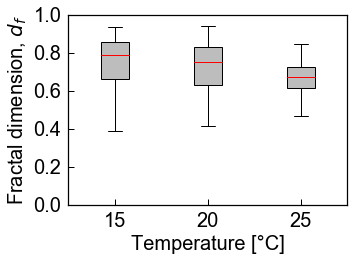

In [229]:
data_to_plot=[list(df_temperature[x].dropna()) for x in list(df_temperature.columns)]
box_plot_temp(data_to_plot,ymin=0,ymax=1,ylabel='Fractal dimension, $d_f$')
plt.savefig('../figures/temp_fractal_dimension.pdf', bbox_inches='tight')

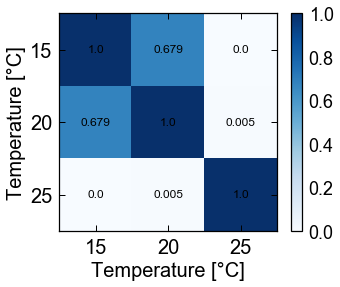

In [232]:
p=test2samples_temp(np.array(data_to_plot))
matrix_plot_temp(p)
plt.savefig('../figures/temp_fractal_dimension_matrix.pdf', bbox_inches='tight')


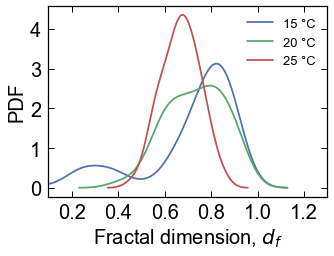

In [235]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(data_to_plot[t],hist=False, rug=False,label=str(t*5+15)+" °C")

ax.legend(fontsize=13) 
ax.set_xlabel('Fractal dimension, $d_f$')
ax.set_ylabel('PDF')
ax.set_xlim(0.1,1.3)
increase_font(ax,20)
plt.savefig('../figures/temp_fractal_dimension_dist.pdf', bbox_inches='tight')

In [231]:
for temp in [0,1,2]:
    print(stats.kstest(data_to_plot[temp], 'norm'))

KstestResult(statistic=0.5600008845455563, pvalue=0.0)
KstestResult(statistic=0.67684562952815674, pvalue=0.0)
KstestResult(statistic=0.68299626335020158, pvalue=0.0)


## DFA

In [236]:
temperature=15
sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
tracks=[i for i in sample_dir.glob('*')]

df_tracks=[]
for track in tracks:
    df_track=pd.read_csv(str(track), index_col=0)
    df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
    df.sort_values(by='time',inplace=True)
    if len(df)>100:
        df_tracks.append(df)

In [237]:
df_tracks[0].head()

,time,x,y,speed,head_speed,mov_forward
8346,1800.0,14.911142,8.752630,0.102395,0.168477,1.0
8347,1800.2,14.934215,8.758602,0.128771,0.178388,1.0
8348,1800.4,14.956489,8.763605,0.123344,0.178388,1.0
8349,1800.6,14.973948,8.766911,0.096008,0.079284,1.0
8350,1800.8,14.992555,8.769965,0.101876,0.009910,1.0


In [238]:
if processdata==True:
    for temperature in [15,20,25]:
        print(temperature)
        sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
        tracks=[i for i in sample_dir.glob('*')]

        df_tracks=[]
        for track in tracks:
            df_track=pd.read_csv(str(track), index_col=0)
            df=df_track[df_track.time>=1800] #Select points with time t>30 minutes
            df.sort_values(by='time',inplace=True)
            if len(df)>100:
                df_tracks.append(df)
        for i in range(0,len(df_tracks)):
            track=df_tracks[i]
            y=np.array(track["speed"])
            df=dfa(y,order=1)
            df.to_csv("../results/dfa/speed-{}-{}.csv".format(temperature,i))
            track=df_tracks[i]
            y=np.array(track["head_speed"])
            df=dfa(y,order=1)
            df.to_csv("../results/dfa/head_speed-{}-{}.csv".format(temperature,i))

### Speed

In [262]:
dfa_temp_tracks=[]
for temperature in [15,20,25]:
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/speed-{}-{}.csv".format(temperature,i))
        temp.append(df)
    dfa_temp_tracks.append(temp)    

In [263]:
dfa_temp_list=[pd.concat(dfa_temp_tracks[t]) for t in [0,1,2]]

-2.706512261692756 0.9244409470714458 0.0153496979697


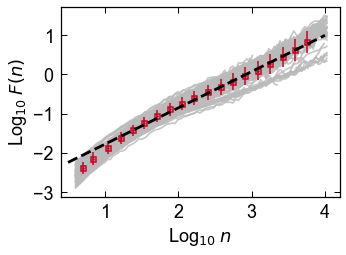

-2.516453261911769 0.904278147302729 0.011999581522


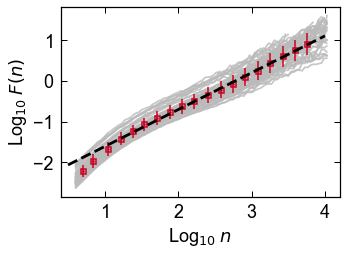

-2.6543985815928686 0.9418798078279615 0.0144598849153


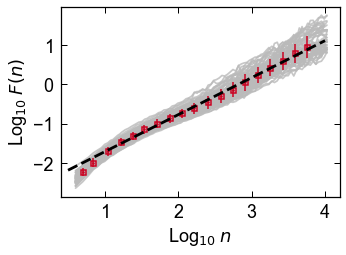

In [264]:
slope_temp=[]
slope_temp_error=[]
for temp in [0,1,2]:
    dataf=dfa_temp_list[temp].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[2:],fw[2:])
    intercept, slope = result.params.tolist()
    slope_temp.append(slope)
    slope_temp_error.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5,3.5))


    for track in range(0,len(dfa_temp_tracks[temp])):
         ax.plot(dfa_temp_tracks[temp][track].n,dfa_temp_tracks[temp][track].F,color="#bababa",alpha=0.8)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

    plt.savefig("../figures/dfa_temp_speed_"+str(temp)+".pdf",bbox_inches='tight')
    plt.show()


In [265]:
temp_list_slope=[]
for t in range(0,3,1):
    temp=[]
    for i in range(0,len(dfa_temp_tracks[t])):
        result=linmodel_fit(dfa_temp_tracks[t][i]["n"],dfa_temp_tracks[t][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    temp_list_slope.append(temp)

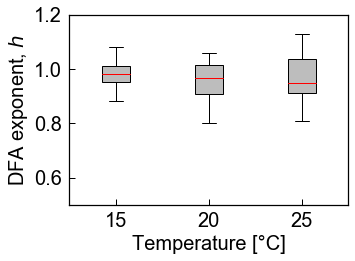

In [270]:
data_to_plot=temp_list_slope
box_plot_temp(data_to_plot,ymin=0.5,ymax=1.2,ylabel='DFA exponent, $h$')
plt.savefig('../figures/temp_speed_dfa.pdf', bbox_inches='tight')

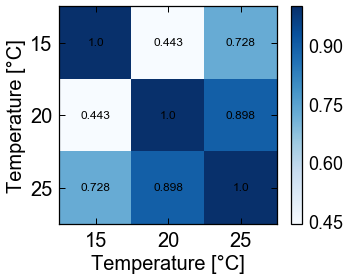

In [267]:
p=test2samples_temp(np.array(data_to_plot))
matrix_plot_temp(p)
plt.savefig('../figures/temp_speed_dfa_matrix.pdf', bbox_inches='tight')

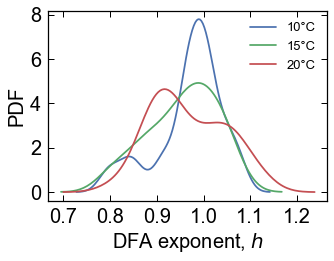

In [268]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(data_to_plot[t],hist=False, rug=False,label=str(10+t*5)+"°C")

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/temp_speed_dfa_dist.pdf', bbox_inches='tight')

In [269]:
for t in [0,1,2]:
    print(stats.kstest(data_to_plot[t], 'norm'))

KstestResult(statistic=0.78463123948989466, pvalue=0.0)
KstestResult(statistic=0.78878709959137772, pvalue=0.0)
KstestResult(statistic=0.79082090221249635, pvalue=0.0)


### Head speed 


In [271]:
dfa_tracks=[]
for temperature in [15,20,25]:
    sample_dir=pathlib.Path('../data/temperature/{}'.format(temperature))
    tracks=[i for i in sample_dir.glob('*')]
    temp=[]
    for i in range(0,len(tracks)):
        df=pd.read_csv("../results/dfa/head_speed-{}-{}.csv".format(temperature,i),index_col=0)
        temp.append(df)
    dfa_tracks.append(temp)

dfa_temp_tracks=dfa_tracks
temp_list_slope=[]
for temperature in [0,1,2]:
    temp=[]
    for i in range(0,len(dfa_tracks[temperature])):
        result=linmodel_fit(dfa_tracks[temperature][i]["n"],dfa_tracks[temperature][i]["F"])
        intercept, slope = result.params.tolist()
        temp.append(slope)
    temp_list_slope.append(temp)

In [272]:
dfa_temp_list=[pd.concat(dfa_tracks[t]) for t in [0,1,2]]

-2.151522342953808 0.7645937238494098 0.00651088222981


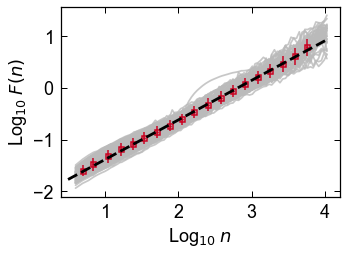

-2.1037951192315156 0.7902772194267813 0.00807797203855


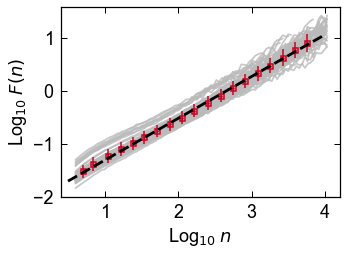

-2.212052944031873 0.8371623679134115 0.0141360509584


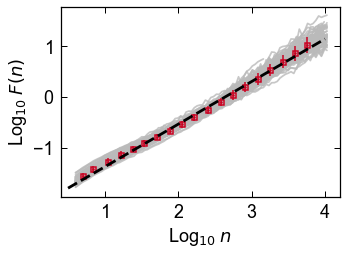

In [273]:
slope_temp=[]
slope_temp_error=[]
for temp in [0,1,2]:
    dataf=dfa_temp_list[temp].sort_index(axis=0, by="n", ascending=True)

    nw,fw=winm(np.array(dataf["n"]),np.array(dataf["F"]),20)
    nwe,fwe=stdm(np.array(dataf["n"]),np.array(dataf["F"]),20)

    result=linmodel_fit(nw[2:],fw[2:])
    intercept, slope = result.params.tolist()
    slope_temp.append(slope)
    slope_temp_error.append(result.bse[1])
    print(intercept, slope,result.bse[1])


    fig, ax = plt.subplots(figsize=(5,3.5))


    for track in range(0,len(dfa_temp_tracks[temp])):
         ax.plot(dfa_temp_tracks[temp][track].n,dfa_temp_tracks[temp][track].F,color="#bababa",alpha=0.8)

    ax.plot(np.array(nw),np.array(fw),"s",markersize=5, fillstyle="none",markeredgecolor = '#ca0020',markeredgewidth=1.5)
    ax.errorbar(np.array(nw),np.array(fw), yerr=np.array(fwe), fmt='.',color="#ca0020",zorder=1000,linewidth=1.5,markersize=5)

    nd=np.array(range(1,9))/2
    ax.plot(np.array(nd), plaw([slope, intercept],np.array(nd)), '--k',linewidth=2.8,zorder=1001)
    ax.set_xlabel('Log$_{10}$ $n$')
    ax.set_ylabel('Log$_{10}$ $F(n)$')
    locx = plticker.MultipleLocator(base=1) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(locx)
    locy = plticker.MultipleLocator(base=1.) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(locy)
    ax.set_xlim(0.4,4.2)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

    plt.savefig("../figures/dfa_temp_head_speed_"+str(temp)+".pdf",bbox_inches='tight')
    plt.show()


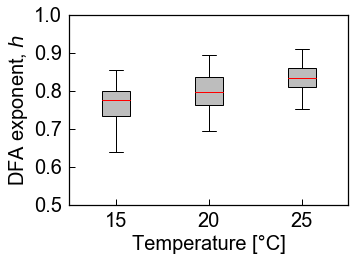

In [274]:
data_to_plot=temp_list_slope
box_plot_temp(data_to_plot,ymin=0.5,ymax=1.,ylabel='DFA exponent, $h$')
plt.savefig('../figures/temp_head_speed_dfa.pdf', bbox_inches='tight')

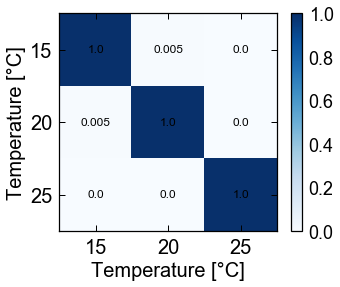

In [275]:
p=test2samples_temp(np.array(data_to_plot))
matrix_plot_temp(p)
plt.savefig('../figures/temp_head_speed_dfa_matrix.pdf', bbox_inches='tight')

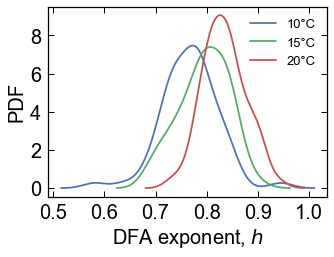

In [277]:
fig = plt.figure(1, figsize=(5,3.5))
ax = fig.add_subplot(111)
for t in [0,1,2]:
    sns.distplot(data_to_plot[t],hist=False, rug=False,label=str(10+t*5)+"°C")

ax.legend(fontsize=13) 
ax.set_xlabel('DFA exponent, $h$')
ax.set_ylabel('PDF')
increase_font(ax,20)
plt.savefig('../figures/temp_head_speed_dfa_dist.pdf', bbox_inches='tight')

In [278]:
for t in [0,1,2]:
    print(stats.kstest(temp_list_slope[t], 'norm'))

KstestResult(statistic=0.72374638885618015, pvalue=0.0)
KstestResult(statistic=0.75623819672387915, pvalue=0.0)
KstestResult(statistic=0.76784511908350428, pvalue=0.0)
